# Librerías

In [6]:
import pandas as pd
import numpy as np
from sklearn.cluster import KMeans
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression
import joblib

import a_funciones as fn

import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

#Para redes
import tensorflow as tf
from keras_tuner.tuners import RandomSearch

from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error as MSE
from sklearn.metrics import r2_score
from sklearn.datasets import load_iris
import xgboost as xgb
import xgboost as xgb
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split

from tensorflow.keras.models import Sequential  # Si defines el modelo
from tensorflow.keras.layers import Dense  # Para crear capas del modelo
from tensorflow.keras.optimizers import Adam  # Optimizador
from tensorflow.keras.metrics import MeanSquaredError, RootMeanSquaredError

# Datos

In [3]:
df_historicos_scaled = joblib.load('salidas/df_filtrado.pkl')
y = joblib.load('salidas/v.respuesta.pkl')
sc = joblib.load('salidas/scaler.pkl')
df_nwecredit = joblib.load('salidas/df_nwecredit_sc')

c:\Users\Manuela\AppData\Local\Programs\Python\Python311\Lib\site-packages\sklearn\base.py:376: InconsistentVersionWarning: Trying to unpickle estimator MinMaxScaler from version 1.4.2 when using version 1.5.1. This might lead to breaking code or invalid results. Use at your own risk. For more info please refer to:
https://scikit-learn.org/stable/model_persistence.html#security-maintainability-limitations
  warnings.warn(


In [9]:
selected_features = [
    'CreditScore', 'DebtRatio', 'Assets', 'Age', 
    'NumberOfDependents', 'EmploymentLength', 
    'YearsAtCurrentAddress', 'HomeOwnership_Own', 
    'MaritalStatus_Widowed', 'Education_Bachelor'
]

# Filtrar el DataFrame con las variables seleccionadas
df_nwecredit_fil = df_nwecredit[selected_features]

# Train / Test

In [4]:
x = df_historicos_scaled

In [7]:
# Separar datos
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size = 0.3, random_state = 42)

#Imprimir Tamaño de dataset, corresponden al 80,20
print("Tamaño del conjunto de entrenamiento. X: ", X_train.shape," Y: ", y_train.shape)
print("Tamaño del conjunto de validación. X: ", X_test.shape," Y: ", y_test.shape )


Tamaño del conjunto de entrenamiento. X:  (7000, 10)  Y:  (7000,)
Tamaño del conjunto de validación. X:  (3000, 10)  Y:  (3000,)


# Modelos

In [8]:
regression_model = tf.keras.models.Sequential([
    tf.keras.layers.Flatten(input_shape=X_train.shape[1:]),
    tf.keras.layers.Dense(1024, activation='relu'),
    tf.keras.layers.Dense(512, activation='relu'),
    tf.keras.layers.Dense(256, activation='relu'),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(64, activation='relu'),
    tf.keras.layers.Dense(32, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
    ])

c:\Users\Manuela\AppData\Local\Programs\Python\Python311\Lib\site-packages\keras\src\layers\reshaping\flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [18]:
# Configurar el optimizador y la función de pérdida para un problema de regresión
regression_model.compile(optimizer='adam', loss='mse', metrics=[MeanSquaredError(), RootMeanSquaredError()])

# Entrenar el modelo usando el optimizador y la arquitectura definidas
regression_model.fit(X_train, y_train, batch_size=100, epochs=10, validation_data=(X_test, y_test))

# Evaluar el modelo
test_loss, test_mse, test_rmse = regression_model.evaluate(X_test, y_test, verbose=2)


Epoch 1/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 12s 27ms/step - loss: 0.0017 - mean_squared_error: 0.0017 - root_mean_squared_error: 0.0411 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_root_mean_squared_error: 0.0387
Epoch 2/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 1s 21ms/step - loss: 0.0016 - mean_squared_error: 0.0016 - root_mean_squared_error: 0.0394 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_root_mean_squared_error: 0.0389
Epoch 3/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 23ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - root_mean_squared_error: 0.0383 - val_loss: 0.0016 - val_mean_squared_error: 0.0016 - val_root_mean_squared_error: 0.0400
Epoch 4/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 2s 25ms/step - loss: 0.0015 - mean_squared_error: 0.0015 - root_mean_squared_error: 0.0393 - val_loss: 0.0015 - val_mean_squared_error: 0.0015 - val_root_mean_squared_error: 0.0385
Epoch 5/10
70/70 ━━━━━━━━━━━━━━━━━━━━ 3s 24ms/step - loss: 0.0014 - mean_squared_error: 0.0014 - root_mean_squared_error: 0

In [19]:
print("MSE:", test_mse)
print("RMSE:", test_rmse)

MSE: 0.0015115955611690879
RMSE: 0.03887924179434776


## Hiperparámetros

In [20]:
def build_model(hp):
    model = tf.keras.models.Sequential()
    model.add(tf.keras.layers.Flatten(input_shape=X_train.shape[1:]))

    # Añadir capas ocultas con hiperparámetros para el número de unidades y la activación
    for i in range(hp.Int('num_layers', 1, 6)):
        model.add(tf.keras.layers.Dense(
            units=64,  # Número fijo de unidades en cada capa
            activation=hp.Choice('activation', ['relu', 'tanh']),
            kernel_initializer=hp.Choice('init_mode', ['uniform', 'he_normal'])
        ))

    model.add(tf.keras.layers.Dense(1, activation='sigmoid'))

    # Compilar el modelo con hiperparámetros para el optimizador
    model.compile(
        optimizer='adam',
        loss='mse',
        metrics=[tf.keras.metrics.MeanSquaredError(), tf.keras.metrics.RootMeanSquaredError()]
    )

    return model

In [12]:
# Crear el tuner
tuner = RandomSearch(
    build_model,
    objective='val_mean_squared_error',
    max_trials=10,
    executions_per_trial=1,
    directory='my_dir',
    project_name='helloworld'
)

# Realizar la búsqueda de hiperparámetros
tuner.search(X_train, y_train, epochs=10, validation_data=(X_test, y_test), batch_size=100)

# Obtener los mejores hiperparámetros
best_hps = tuner.get_best_hyperparameters(num_trials=1)[0]


# Mostrar los mejores hiperparámetros
print("Best Hyperparameters:")
print(f"- Number of layers: {best_hps.get('num_layers')}")


Reloading Tuner from my_dir\helloworld\tuner0.json
Best Hyperparameters:
- Number of layers: 6


## Predicciones

In [13]:
# Hacer predicciones con el modelo entrenado
y_pred_nuevos = regression_model.predict(df_nwecredit_fil)

34/34 ━━━━━━━━━━━━━━━━━━━━ 1s 11ms/step


94/94 ━━━━━━━━━━━━━━━━━━━━ 0s 3ms/step


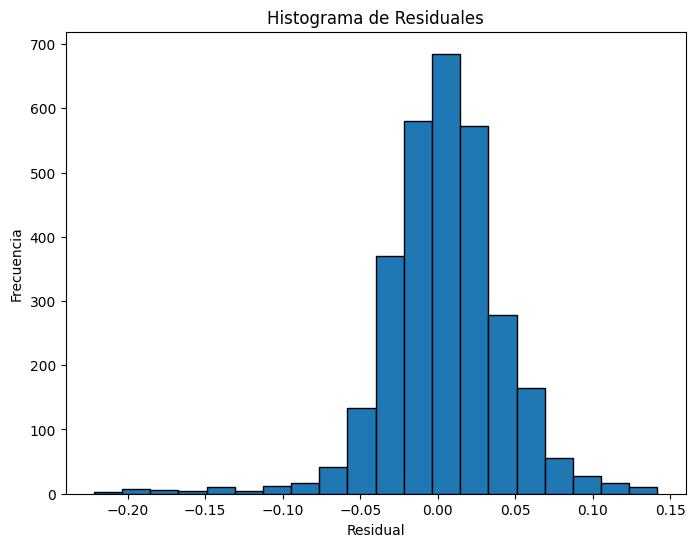

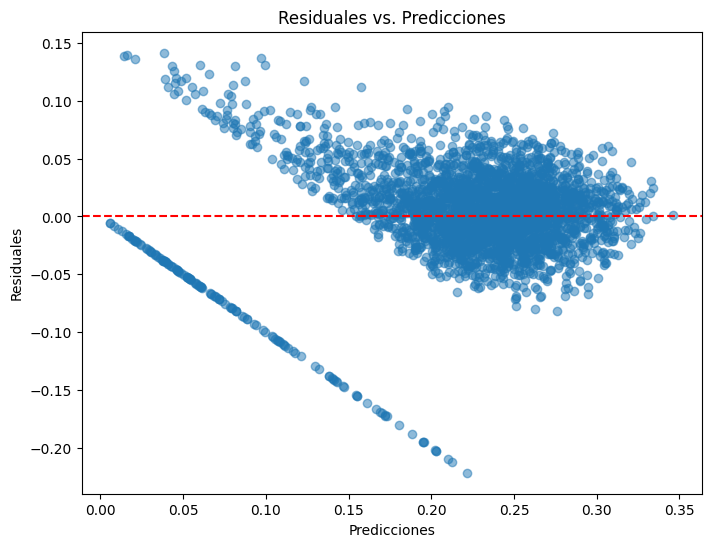

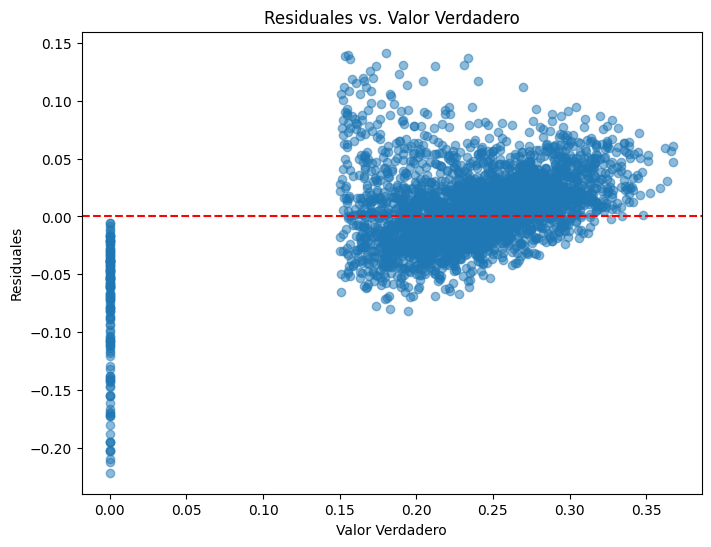

In [14]:
# Obtener las predicciones del modelo en los datos de prueba
y_pred = regression_model.predict(X_test).flatten()

# Calcular los residuales
residuales = y_test - y_pred

# Histograma de los residuales
plt.figure(figsize=(8, 6))
plt.hist(residuales, bins=20, edgecolor='k')
plt.title('Histograma de Residuales')
plt.xlabel('Residual')
plt.ylabel('Frecuencia')
plt.show()

# Gráfico de dispersión de los residuales vs. predicciones
plt.figure(figsize=(8, 6))
plt.scatter(y_pred, residuales, alpha=0.5)
plt.title('Residuales vs. Predicciones')
plt.xlabel('Predicciones')
plt.ylabel('Residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

# Gráfico de dispersión de los residuales vs. el valor verdadero
plt.figure(figsize=(8, 6))
plt.scatter(y_test, residuales, alpha=0.5)
plt.title('Residuales vs. Valor Verdadero')
plt.xlabel('Valor Verdadero')
plt.ylabel('Residuales')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

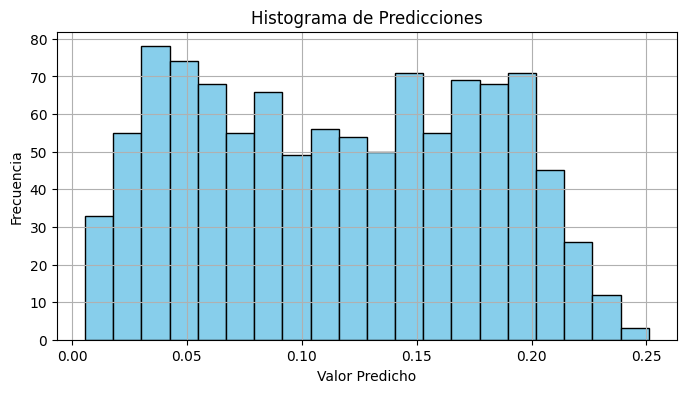

In [15]:
# Crear el histograma de las predicciones
plt.figure(figsize=(8, 4))
plt.hist(y_pred_nuevos, bins=20, color='skyblue', edgecolor='black')
plt.title('Histograma de Predicciones')
plt.xlabel('Valor Predicho')
plt.ylabel('Frecuencia')
plt.grid(True)
plt.show()

In [17]:
df_predic = df_nwecredit_fil.copy()
df_predic['NoPaidPer'] = y_pred_nuevos
df_predic

,CreditScore,DebtRatio,Assets,Age,NumberOfDependents,EmploymentLength,YearsAtCurrentAddress,HomeOwnership_Own,MaritalStatus_Widowed,Education_Bachelor,NoPaidPer
0,0.795993,0.479108,0.083183,0.633803,0.666667,0.517241,0.689655,0.0,1.0,0.0,0.096210
1,0.202186,0.442984,0.202533,0.140845,0.777778,0.137931,0.724138,0.0,1.0,0.0,0.075769
2,0.786885,0.532386,0.314275,0.112676,0.555556,0.344828,0.344828,0.0,1.0,0.0,0.060166
3,0.746812,0.295565,0.370849,0.464789,0.888889,0.620690,0.586207,0.0,1.0,0.0,0.043088
4,0.998179,0.248392,0.457161,0.154930,0.444444,0.034483,0.896552,1.0,1.0,0.0,0.073379
...,...,...,...,...,...,...,...,...,...,...,...
1053,0.551913,0.257387,0.888341,0.267606,0.000000,0.034483,0.793103,0.0,1.0,0.0,0.096200
1054,0.746812,0.691069,0.879445,0.422535,0.666667,0.482759,0.482759,0.0,1.0,1.0,0.197179
1055,0.622951,0.099053,0.974074,0.380282,0.555556,0.206897,0.758621,1.0,0.0,0.0,0.196905
1056,0.892532,0.164649,0.498811,0.577465,0.888889,0.586207,0.965517,1.0,1.0,0.0,0.099040
